In [37]:
# Import the Earth Engine Python Package
import ee # !pip install earthengine-api

# Import Dependencies
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from datetime import datetime
from matplotlib import dates
from pylab import *

import geopandas as gpd

ee.Initialize()

In [227]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../TreeTect/data/shapefiles_waterbodies_osm/*.shp'
shape_files = glob.glob(shape_file_path)
path = shape_files[6]

shape_files, cwd, path

(['../../TreeTect/data/shapefiles_waterbodies_osm/Cilegon_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Denpasar_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Jakarta_hand.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Test area CGI.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Balikpapan_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Manila_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Medan_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Jakarta_hand_water.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Shape_Jakarta_003_pansharpen_True_2018-09-13_03:30_1030010085B5FC00.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Cutout_shapes.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Jakarta_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Denpasar_hand.shp'],
 '/home/chris/Documents/GreenCityWatch/GCW_toolkit/05_Green_spac

In [228]:
shapefile.shape[0]

38

In [262]:
shapefile = gpd.read_file(path)

features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 


In [263]:
fc = ee.FeatureCollection(features)

In [264]:
shp_AOIs = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 
id_list = [pol['id'] for pol in fiona.open(path)]

TypeError: 'Polygon' object is not callable

In [265]:
i = 0

sizes = []

for shape in shp_AOIs: 
    
    x = np.array(shape.exterior.coords.xy).T[:,0]
    y = np.array(shape.exterior.coords.xy).T[:,1]
    
    delta = x.max() - x.min()
    sizes.append([delta])

#     plt.title([i, delta])
#     plt.plot(x,y)
#     plt.axis('equal')
#     plt.show()
    
    i = i + 1

In [250]:
biggest_poly_index = np.array(sizes).argmax()

In [266]:
osm_polygon = np.array(shp_AOIs[biggest_poly_index].buffer(0.001).exterior.coords.xy).T


In [267]:
polygon_list = osm_polygon[0:-1].tolist()

In [268]:
input_data = [[106.81591544702997, -6.33681462466857],
          [106.81591544702997, -6.350036929099756],
          [106.82780299738397, -6.350036929099756],
          [106.82780299738397, -6.33681462466857]]

In [269]:
type(input_data)

list

In [270]:
# set variables
SCALE = 10;
polarization = 'VV'; # vertical/vertical or vertical/horizontal

In [271]:
# build geometry to measure
rect = ee.Geometry.Polygon(
        [polygon_list])

In [272]:
# convert geometry to JSON format
rect_JSON = rect.getInfo()['coordinates']

In [273]:
# initiate google earth engine to aquire the image
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
.filterDate('2016-01-01', '2019-12-12')\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
.select(polarization)\
.filterBounds(rect);

In [274]:
# visualize resulting image
img_url = S1.first().getThumbUrl({
    'region':rect_JSON,
    'min':-25,
    'max':0,
    'palette':['0784b5', '39ace7', '9bd4e4', 'cadeef', 'ffffff']
})

# Image(url = img_url)

In [275]:
img_url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f06e745e4e5c38f8f9dcbfaf4f4ac1b3-418875aa9bd9b1eea367f8d6e119c168:getPixels'

(58, 378, 4)


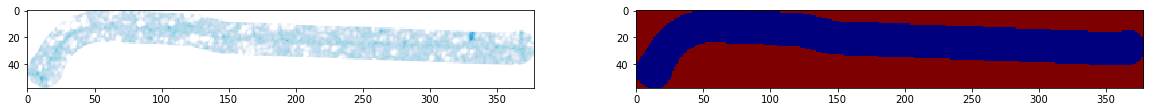

In [276]:
import imageio

# download image as np array
im = imageio.imread(img_url)

# apply value mask
array_mask = np.array(im == 0).astype(int)

print(array_mask.shape)

# plot results
plt.figure(figsize = (20,20))
plt.subplot(121)
plt.imshow(im, cmap = 'jet')
plt.subplot(122)
plt.imshow(array_mask[:,:,0], cmap = 'jet')